## Section 1.

In [4]:
import glob
import os
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import re
import kagglehub
import numpy as np
import torch
import torch.nn as nn
import shutil


from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, classification_report


### 데이터셋 다운로드

In [5]:
# Download latest version
path = kagglehub.dataset_download("protobioengineering/mit-bih-arrhythmia-database-modern-2023")
target_dir = "/home/subject/reliable_AI/subject/data"

shutil.copytree(path, target_dir, dirs_exist_ok=True)

print("Dataset moved to:", target_dir)

Dataset moved to: /home/subject/reliable_AI/subject/data


In [6]:
def load_segment(path, start=0, length=1000):
    df = pd.read_csv(path)
    
    if "MLII" not in df.columns:
        raise ValueError(f"'MLII' not found in {path}")
    
    signal = df["MLII"].values
    segment = signal[start:start+length]
    
    if len(segment) < length:
        segment = np.pad(segment, (0, length - len(segment)))
    return segment


부정맥/정상을 메타데이터에 따라 사전 라벨링 
- 출처: https://archive.physionet.org/physiobank/database/html/mitdbdir/records.htm#100

In [8]:
target_dir = "/home/subject/reliable_AI/subject/data"
files = sorted(glob.glob(os.path.join(target_dir, "*.csv")))
arrhythmia_ids = {100, 105, 106, 107, 108, 109, 114, 116, 118, 119, 124, 200, 201, 202, 203, 205,
                  207, 208, 209, 210, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 231, 232, 233, 234}

normal_ids = {101, 103, 111, 112, 113, 115, 117, 121, 122, 123, 212, 230}

record_ids = [] 
# MLII 채널이 있는 파일만 필터링
valid_files = []
for f in files:
    filename = os.path.basename(f)
    record_id = int(''.join(filter(str.isdigit, filename)))

    try:
        df = pd.read_csv(f, nrows=1)  # 빠르게 컬럼만 확인
        if "MLII" in df.columns:
            record_ids.append(record_id)
            valid_files.append(f)

    except Exception as e:
        print(f"Failed to read {f}: {e}")

print(f"'MLII' 있는 파일 수: {len(valid_files)}")

# 최대 100개까지만 불러오기
segments = [load_segment(f) for f in valid_files[:100]]
X = np.stack(segments)
y = np.array([1 if rid in arrhythmia_ids else 0 for rid in record_ids])

'MLII' 있는 파일 수: 46


In [4]:
print(X.shape)
print(y.shape)

(46, 1000)
(46,)


In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Step 1: 6:2:2 split (train:valid:test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Step 2: Tensor 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 3: Dataset & DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


### 모델 구조 정의

In [10]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.model(x)


# 모델 학습 + 검증
model = MLPClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### 학습 루프 설정

In [11]:
from torch.nn.functional import softmax
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 검증
    model.eval()
    valid_preds = []
    valid_targets = []
    with torch.no_grad():
        for batch_x, batch_y in valid_loader:
            outputs = model(batch_x)
            preds = torch.argmax(outputs, dim=1)
            valid_preds.extend(preds.tolist())
            valid_targets.extend(batch_y.tolist())

    valid_acc = accuracy_score(valid_targets, valid_preds)
    avg_train_loss = train_loss / len(train_loader)
    print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Valid Acc: {valid_acc:.2%}")

from sklearn.metrics import accuracy_score, roc_auc_score
from torch.nn.functional import softmax

model.eval()
test_probs = []
test_targets = []
test_preds = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        probs = softmax(outputs, dim=1)
        test_probs.extend(probs[:, 1].tolist())  # 클래스 1 확률
        test_preds.extend(torch.argmax(probs, dim=1).tolist())
        test_targets.extend(batch_y.tolist())

# 정확도 및 ROC-AUC
test_acc = accuracy_score(test_targets, test_preds)

print(f"\n Final Test Accuracy: {test_acc:.2%}")




[Epoch 0] Train Loss: 0.6815 | Valid Acc: 66.67%
[Epoch 1] Train Loss: 0.6421 | Valid Acc: 66.67%
[Epoch 2] Train Loss: 0.6293 | Valid Acc: 66.67%
[Epoch 3] Train Loss: 0.6026 | Valid Acc: 66.67%
[Epoch 4] Train Loss: 0.5849 | Valid Acc: 66.67%
[Epoch 5] Train Loss: 0.5946 | Valid Acc: 66.67%
[Epoch 6] Train Loss: 0.5985 | Valid Acc: 66.67%
[Epoch 7] Train Loss: 0.5844 | Valid Acc: 77.78%
[Epoch 8] Train Loss: 0.5373 | Valid Acc: 77.78%
[Epoch 9] Train Loss: 0.5369 | Valid Acc: 77.78%
[Epoch 10] Train Loss: 0.5639 | Valid Acc: 77.78%
[Epoch 11] Train Loss: 0.5519 | Valid Acc: 77.78%
[Epoch 12] Train Loss: 0.5503 | Valid Acc: 77.78%
[Epoch 13] Train Loss: 0.5112 | Valid Acc: 77.78%
[Epoch 14] Train Loss: 0.4992 | Valid Acc: 77.78%
[Epoch 15] Train Loss: 0.4947 | Valid Acc: 77.78%
[Epoch 16] Train Loss: 0.5092 | Valid Acc: 77.78%
[Epoch 17] Train Loss: 0.5077 | Valid Acc: 77.78%
[Epoch 18] Train Loss: 0.5182 | Valid Acc: 77.78%
[Epoch 19] Train Loss: 0.4972 | Valid Acc: 77.78%
[Epoch 20]

### 모델을 onnx 형식으로 저장

In [14]:
dummy_input = torch.zeros(1, 1000)  # (batch_size=1, channels=1, length=1000)
torch.onnx.export(
    model, dummy_input, "pulse.onnx",
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)


### Domain Knowledge
1. P파 (심방 탈분극)
- x190, x200, x210
→ 미세한 상승과 완만한 하강을 가지며, 작지만 명확한 피크를 형성해야 함
→ 심방 활동의 존재를 나타냄

2. QRS complex (심실 탈분극)
- x300, x310, x320
→ 매우 짧은 시간에 sharp하게 변하는 강한 신호
→ R파는 높고 뾰족해야 하며, Q/S는 급격한 하강/회복을 나타냄
→ 정상적인 심실 수축의 핵심 지표

3. T파 (심실 재분극)
- x500, x520, x540
→ 완만하게 올라갔다가 내려오는 곡선
→ peak가 일정 이상 높아야 재분극이 정상적으로 완료되었음을 시사

In [15]:
with open("mlp_input.txt", "w") as f:
    # 전체 입력 도메인 제약 (정규화된 ECG)
    for i in range(1000):
        f.write(f"x{i} >= -0.5\n")
        f.write(f"x{i} <= 1\n")

    # --- Domain-specific constraints ---\n

    # P파가 존재해야 한다 (미세한 상승)
    f.write("x190 >= 0.1\n")      # 부드러운 상승
    f.write("x200 >= 0.3\n")      # 피크
    f.write("x210 >= 0.2\n")      # 완만한 하강

    # QRS complex는 sharp하고 peak가 커야 한다
    f.write("x300 <= 0.1\n")      # Q-wave: 가파른 하강
    f.write("x310 >= 0.9\n")      # R-wave: 강한 피크
    f.write("x320 <= 0.1\n")      # S-wave: 빠른 회복

    # T파는 완만하고 충분히 높은 peak
    f.write("x500 >= 0.3\n")      # T파 시작
    f.write("x520 >= 0.5\n")      # 피크
    f.write("x540 >= 0.3\n")      # 하강 완료

    # 이상적이지 않은 조건도 포함 (부정맥 가능성 증가 조건)
    # QT 간격 비정상적 길이 시사
    f.write("x600 >= 0.7\n")      # Repolarization 이상

    # 출력 제약: 부정맥일 가능성이 높은 출력
    f.write("y1 >= 0.65\n")   # 부정맥 클래스의 logit이 확실히 더 크도록


## Section 2. 

### marabou 이후 핵심 검증 결과를 추출

In [16]:
# Load the result file
file_path = Path("result.txt")
with open(file_path, "r") as f:
    content = f.read()

# Extract key Marabou outputs
result = {
    "sat_status": None,
    "output_values": {},
    "main_loop_iterations": None,
    "total_time_elapsed": None,
}

# SAT status
sat_match = re.search(r"\n(sat|unsat|unknown)\n", content)
if sat_match:
    result["sat_status"] = sat_match.group(1)

# Output values
output_matches = re.findall(r"y(\d+)\s*=\s*(-?\d+\.\d+)", content)
result["output_values"] = {f"y{m[0]}": float(m[1]) for m in output_matches}

# Main loop iterations
main_loop_match = re.search(r"Number of main loop iterations: (\d+)", content)
if main_loop_match:
    result["main_loop_iterations"] = int(main_loop_match.group(1))

# Total time elapsed
time_match = re.search(r"Total time elapsed: (\d+)\s+milli", content)
if time_match:
    result["total_time_elapsed"] = int(time_match.group(1))

# Convert result to dataframe for display
summary_df = pd.DataFrame([
    {"Key": "SAT Status", "Value": result["sat_status"]},
    {"Key": "Output y0", "Value": result["output_values"].get("y0", "N/A")},
    {"Key": "Output y1", "Value": result["output_values"].get("y1", "N/A")},
    {"Key": "Main Loop Iterations", "Value": result["main_loop_iterations"]},
    {"Key": "Total Time Elapsed (ms)", "Value": result["total_time_elapsed"]},
])
summary_df

,Key,Value
0,SAT Status,sat
1,Output y0,-0.474904
2,Output y1,0.65
3,Main Loop Iterations,1
4,Total Time Elapsed (ms),11783


### 원래 부정맥인 샘플 시각화

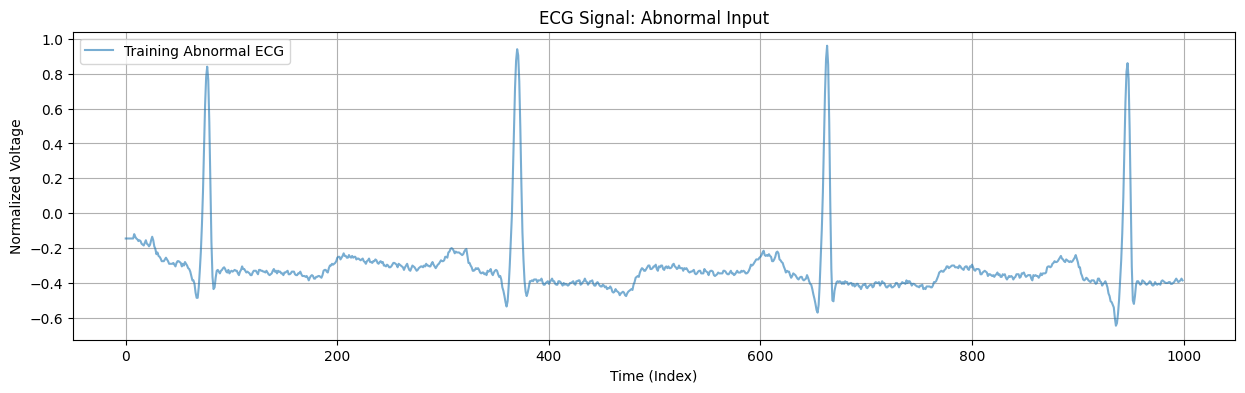

In [42]:
abnormal_indices = np.where(y == 1)[0][0]
x_abnormal = X[abnormal_indices]
# 시각화
plt.figure(figsize=(15, 4))
plt.plot(x_abnormal, label="Training Abnormal ECG", alpha=0.6)

plt.legend()
plt.title("ECG Signal: Abnormal Input")
plt.xlabel("Time (Index)")
plt.ylabel("Normalized Voltage")
plt.grid(True)
plt.show()


### Marabou로 만든 샘플

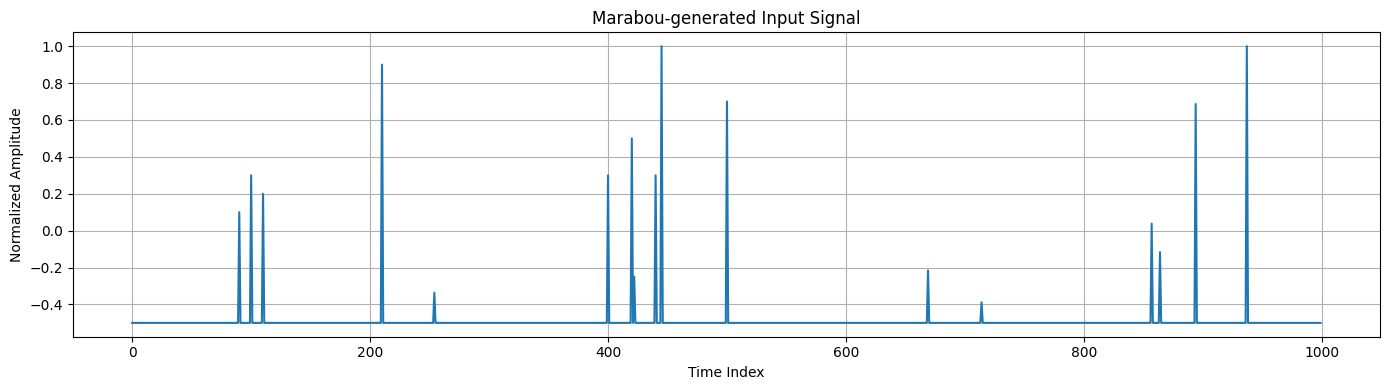

In [36]:
import re
import matplotlib.pyplot as plt
import numpy as np

# x0 ~ x719 값 파싱
matches = re.findall(r"x(\d+)\s*=\s*(-?\d+\.\d+)", content)
matches = [(int(i), float(val)) for i, val in matches if int(i) < 1000]
matches.sort(key=lambda x: x[0])
x_indices, x_values = zip(*matches)

plt.show()
# 시각화
plt.figure(figsize=(14, 4))
plt.plot(x_indices, x_values)  # <-- marker='o' 제거
plt.title("Marabou-generated Input Signal")
plt.xlabel("Time Index")
plt.ylabel("Normalized Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()
